# Bag of Words Model

This document has two sections:

<ol>
<li> <b>Build BoW model from scratch:</b><p>
this way we can see the simple steps involved in building BoW models.</li>

<li> <b>Build BoW model with scikit-learn</b>: <p>this is the normal way to build BoW models. This section is meant to provide inspiration for the BoW section of the assignment. Here we work with a subset of the banking77 dataset, which you should also use for the assignment.</li>
</ol>


<div style="padding-left: 10px; padding-right: 10px; padding-top: 10px; padding-bottom: 30px, align: justify">
<p align="center">
<img src="../media/bow_slp1.png" alt="Transformer Architecture" width="500"/>
</p>
</div>


# An introduction to bag-of-words models

* A bag-of-words model is a type of vector representation for text data that describes the occurrence of words within a document. We transform each document into a vector of word counts or frequencies. This vectorization enables standard machine learning methods.<br><br>

---

Any text (or document) can be transformed into  an unordered set of words with their position ignored, keeping only their frequency in the document. In the example in the figure, instead of representing the word order in all the phrases like “<i>I love this movie</i>” and “<i>I would recommend it</i>”, we simply note that the word I occurred 5 times in the entire excerpt, the word it 6 times, the words love, recommend, and movie once, and so on. In other words, no pun intended, the position of the words is ignored (the bag-of-words assumption) and we make use of the *frequency* of each word.


# Section 1. BoW From Scratch

In this section, we will build a bag-of-words model from scratch. Let's assume we have the same text as in the image above:

In [1]:
document = "I love this movie! It's sweet, but with satirical humor. The dialogue is great and the adventure scenes are fun... It manages to be whimsical and romantic while laughing at the conventions of the fairy tale genre. I would recommend it to just about anyone. I've seen it several times, and I'm always happy to see it again whenever I have a friend who hasn't seen it yet!"
document

"I love this movie! It's sweet, but with satirical humor. The dialogue is great and the adventure scenes are fun... It manages to be whimsical and romantic while laughing at the conventions of the fairy tale genre. I would recommend it to just about anyone. I've seen it several times, and I'm always happy to see it again whenever I have a friend who hasn't seen it yet!"

We  count the frequency of each word in the text. 

In [2]:
# split the document into words
words = document.split() # split the document into words by whitespace

# create a dictionary to store the frequency of each word
word_freq = {}
for word in words:
    if word in word_freq:
        word_freq[word] += 1
    else:
        word_freq[word] = 1

print(word_freq)

{'I': 3, 'love': 1, 'this': 1, 'movie!': 1, "It's": 1, 'sweet,': 1, 'but': 1, 'with': 1, 'satirical': 1, 'humor.': 1, 'The': 1, 'dialogue': 1, 'is': 1, 'great': 1, 'and': 3, 'the': 3, 'adventure': 1, 'scenes': 1, 'are': 1, 'fun...': 1, 'It': 1, 'manages': 1, 'to': 3, 'be': 1, 'whimsical': 1, 'romantic': 1, 'while': 1, 'laughing': 1, 'at': 1, 'conventions': 1, 'of': 1, 'fairy': 1, 'tale': 1, 'genre.': 1, 'would': 1, 'recommend': 1, 'it': 4, 'just': 1, 'about': 1, 'anyone.': 1, "I've": 1, 'seen': 2, 'several': 1, 'times,': 1, "I'm": 1, 'always': 1, 'happy': 1, 'see': 1, 'again': 1, 'whenever': 1, 'have': 1, 'a': 1, 'friend': 1, 'who': 1, "hasn't": 1, 'yet!': 1}


## A Corpus

We can build a BoW for any collection of texts. Here we have a corpus of 8 sentences.

In [3]:
corpus = [
    "Natural Language Processing (NLP) is a fascinating field of study, which involves the interaction between computers and humans using natural language.",
    "The goal of NLP is to enable computers to understand, interpret, and generate human language in a way that is both meaningful and useful.",
    "There are many challenges in NLP, such as dealing with the ambiguity and variability of natural language.",
    "Techniques in NLP include tokenization, stemming, lemmatization, and part-of-speech tagging, among others.",
    "Applications of NLP are vast and include machine translation, sentiment analysis, and speech recognition.",
    "In recent years, deep learning has revolutionized NLP, leading to significant improvements in tasks like language modeling and text generation.",
    "Despite these advancements, there are still many open problems in NLP, such as understanding context and handling low-resource languages.",
    "Researchers in NLP are continually developing new methods and models to address these challenges and improve the performance of NLP systems."
]

## Preprocessing

Lowercase, remove punctuation and separate words using whitespace.

In [4]:
def preprocess_text(text):


    # 1. Convert the text to lowercase
    text = text.lower()

    # 2. Remove punctuation by building a new string without those characters
    # Define punctuation characters explicitly (since we are not using any libraries)
    punctuation_chars = ".,!?;:'\"()"
    text = ''.join(char for char in text if char not in punctuation_chars)

    # 3. Tokenize by splitting on whitespace
    tokens = text.split()

    return tokens

# Process the document and print results
tokens = preprocess_text(document)
print(tokens)


['i', 'love', 'this', 'movie', 'its', 'sweet', 'but', 'with', 'satirical', 'humor', 'the', 'dialogue', 'is', 'great', 'and', 'the', 'adventure', 'scenes', 'are', 'fun', 'it', 'manages', 'to', 'be', 'whimsical', 'and', 'romantic', 'while', 'laughing', 'at', 'the', 'conventions', 'of', 'the', 'fairy', 'tale', 'genre', 'i', 'would', 'recommend', 'it', 'to', 'just', 'about', 'anyone', 'ive', 'seen', 'it', 'several', 'times', 'and', 'im', 'always', 'happy', 'to', 'see', 'it', 'again', 'whenever', 'i', 'have', 'a', 'friend', 'who', 'hasnt', 'seen', 'it', 'yet']


In [5]:
preprocessed_documents = [preprocess_text(doc) for doc in corpus]

print(f"{len(preprocessed_documents)=} | {len(corpus)=}\n")
print(preprocessed_documents)

# Create word_freq = {}
for tokens in preprocessed_documents:
    for word in tokens:
        if word in word_freq:
            word_freq[word] += 1
        else:
            word_freq[word] = 1

print(f"{len(word_freq)=}\n")
print(word_freq) # a dictionary to store the frequency of each word in the corpus


len(preprocessed_documents)=8 | len(corpus)=8

[['natural', 'language', 'processing', 'nlp', 'is', 'a', 'fascinating', 'field', 'of', 'study', 'which', 'involves', 'the', 'interaction', 'between', 'computers', 'and', 'humans', 'using', 'natural', 'language'], ['the', 'goal', 'of', 'nlp', 'is', 'to', 'enable', 'computers', 'to', 'understand', 'interpret', 'and', 'generate', 'human', 'language', 'in', 'a', 'way', 'that', 'is', 'both', 'meaningful', 'and', 'useful'], ['there', 'are', 'many', 'challenges', 'in', 'nlp', 'such', 'as', 'dealing', 'with', 'the', 'ambiguity', 'and', 'variability', 'of', 'natural', 'language'], ['techniques', 'in', 'nlp', 'include', 'tokenization', 'stemming', 'lemmatization', 'and', 'part-of-speech', 'tagging', 'among', 'others'], ['applications', 'of', 'nlp', 'are', 'vast', 'and', 'include', 'machine', 'translation', 'sentiment', 'analysis', 'and', 'speech', 'recognition'], ['in', 'recent', 'years', 'deep', 'learning', 'has', 'revolutionized', 'nlp', 'leading'

In [6]:
def build_document_term_matrix(preprocessed_documents):
    """
    Builds a Bag-of-Words document-term matrix.
    Returns:
    - document_term_matrix (list of lists): BoW representation of documents
    - vocab (list): Sorted vocabulary of unique words
    - word_to_index (dict): Mapping of word → index in vocabulary
    """
    # 1. Extract unique vocabulary from the dataset and sort it
    vocab = sorted(set(word for doc in preprocessed_documents for word in doc))

    # 2. Create a word-to-index mapping
    word_to_index = {word: idx for idx, word in enumerate(vocab)}

    # 3. Convert each document into a vector
    document_term_matrix = []
    
    for tokens in preprocessed_documents:
        doc_vector = [0] * len(vocab)  # Initialize a vector of zeros
        for token in tokens:
            if token in word_to_index:
                doc_vector[word_to_index[token]] += 1  # Increment word count
        document_term_matrix.append(doc_vector)

    print(f"\nVocabulary Size: {len(vocab)} | Number of Documents: {len(document_term_matrix)}\n")
    # Print vectors for first two sentences 
    for i, vector in enumerate(document_term_matrix[:2]):
        print(f"Document {i} vector:\n{vector}\n")
        print(f"Document {i} text:\n{preprocessed_documents[i]}\n\n{'#'*50}\n")

    # Optionally, we can inspect the shape of our document-term matrix
    print(f"Number of documents: {len(document_term_matrix)}")
    print(f"Vocabulary size: {len(vocab)}")

    return document_term_matrix, vocab, word_to_index

document_term_matrix, vocab, word_to_index = build_document_term_matrix(preprocessed_documents)


Vocabulary Size: 94 | Number of Documents: 8

Document 0 vector:
[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0]

Document 0 text:
['natural', 'language', 'processing', 'nlp', 'is', 'a', 'fascinating', 'field', 'of', 'study', 'which', 'involves', 'the', 'interaction', 'between', 'computers', 'and', 'humans', 'using', 'natural', 'language']

##################################################

Document 1 vector:
[1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 2, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]

Document 1 text:
['the', 'goal', 'of', 'nlp', 'is', 'to', 'enable'

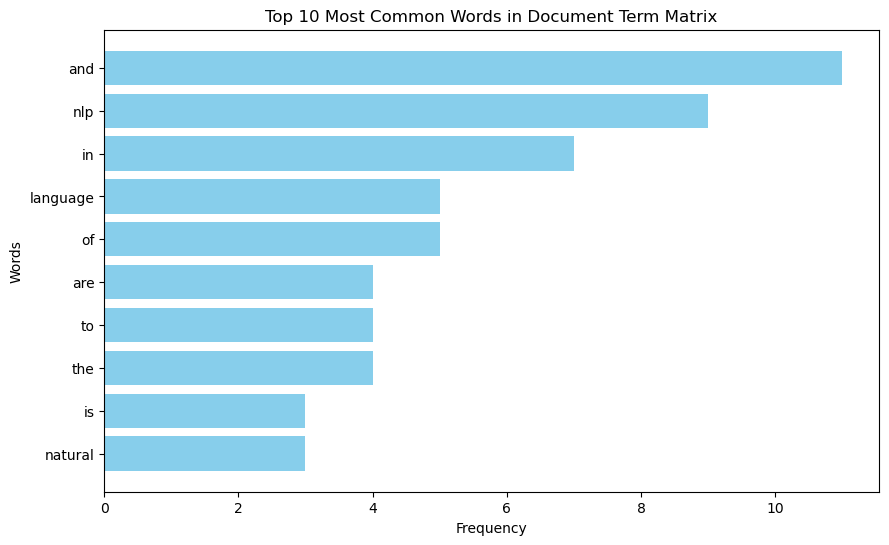

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def visualize_top_n_tokens(n, document_term_matrix):

    # Sum the occurrences of each word across all documents
    word_counts = np.sum(document_term_matrix, axis=0)

    # Get the indices of the top n most common words
    top_n_indices = np.argsort(word_counts)[-n:]

    # Get the corresponding words and their counts
    top_n_words = [vocab[i] for i in top_n_indices]
    top_n_counts = word_counts[top_n_indices]

    # Create the bar chart
    plt.figure(figsize=(10, 6))
    plt.barh(top_n_words, top_n_counts, color='skyblue')
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.title(f'Top {n} Most Common Words in Document Term Matrix')
    plt.show()

visualize_top_n_tokens(10, document_term_matrix)

# Section 2. BoW Using Scikit Learn

Normally we build BoW models using CountVectorizer and other tools from scikit-learn. CountVectorizer does  preprocessing and builds word vectors, using fit_transform, as we will see below. Also, it provides a elaborate set of options for preprocessing.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report
from pathlib import Path



*Change Current Directory if needed*

In [9]:

print(f"Working directory set to: {Path.cwd()}")
#os.chdir("../ma2")
#print(f"Working directory set to: {Path.cwd()}")



Working directory set to: /Users/danielhardt/CBS Dropbox/Daniel Hardt/courses/spring_2025/ai_ml/MA/ma2


<h2>Read Data</h2>

In [14]:
# read data

df = pd.read_csv("data/banking77_top10_labels.csv")
print(df.columns)
texts = df['text']
labels = df['label']


Index(['text', 'label'], dtype='object')


## Bag of Words with CountVectorizer

In [15]:

# countvectorizer
cv = CountVectorizer()
features = cv.fit_transform(texts)

train_features, test_features, train_labels, test_labels = train_test_split(features, labels, random_state=42)


## Create Classifier

In [16]:
# create classifier
# logreg

print("LogisticRegression")
lr_clf = LogisticRegression()

lr_clf.fit(train_features, train_labels)




LogisticRegression


LogisticRegression()

## Score Model

In [17]:
print("Train score",lr_clf.score(train_features, train_labels))
print("Test score",lr_clf.score(test_features, test_labels))



Train score 0.9969834087481146
Test score 0.909706546275395


## Classification Report

In [18]:
test_predictions = lr_clf.predict(test_features)

print(classification_report(test_labels, test_predictions))

              precision    recall  f1-score   support

           5       0.88      0.81      0.84        43
           6       0.96      0.96      0.96        47
          15       0.89      0.89      0.89        53
          19       0.95      0.91      0.93        43
          26       0.91      1.00      0.95        41
          28       0.94      0.96      0.95        51
          63       0.97      0.93      0.95        42
          64       0.83      0.81      0.82        36
          66       0.82      0.88      0.85        48
          75       0.95      0.95      0.95        39

    accuracy                           0.91       443
   macro avg       0.91      0.91      0.91       443
weighted avg       0.91      0.91      0.91       443

